# 0.0. Imports

In [55]:
import numpy  as np
import pandas as pd
import scikitplot as skplt
import os
import psycopg2 as pg
import pandas.io.sql as psql

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import ensemble        as en
from sklearn import neighbors       as nh 
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
# Credenciais do Banco de dados Postgress
param_dict={
    'USER': os.getenv('USER_CDS'),
    'HOST': os.getenv('HOST_CDS'),
    'PORT': os.getenv('PORT_NUM'),
    'DATABASE': os.getenv('DATABASE_CDS'),
    'PWD': os.getenv('PWD_CDS')
}

# Acessando os dados com SQL

conn = pg.connect(user=param_dict['USER'],
                  password= param_dict['PWD'],
                  host=param_dict['HOST'],
                  port=param_dict['PORT'],
                  database=param_dict['DATABASE'])

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

query ='''
SELECT *
FROM pa004.users u inner join pa004.vehicle v on (u.id=v.id)
                   inner join pa004.insurance i on (u.id = i.id)
'''
df_raw=psql.read_sql(query, conn)
#df_raw= df_raw.drop(df_raw.columns[[5,9]], axis=1)
conn.close()



# 1.0. Data Description

In [15]:
df_aux= df_raw.copy
df1 = df_raw.copy()

df1= df1.drop(df1.columns[[5]], axis=1)
df1['id']=df_raw.iloc[:,0]
df1= df1[['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response']]

## 1.1. Data Dimension

In [12]:
print( 'Number of Rows:{}'.format( df1.shape[0] ) )
print( 'Number of Columns:{}'.format( df1.shape[1] ) )

Number of Rows:381109
Number of Columns:12


## 1.2. Data Types

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [19]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [20]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [23]:
# Vehicle Damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# 3.0. Data Filtering

In [25]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis

In [57]:
df4 = df3.copy()

## 4.1. Univariate Analysys

<AxesSubplot:xlabel='response', ylabel='age'>

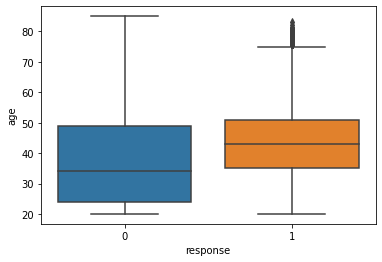

In [27]:
# gender
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

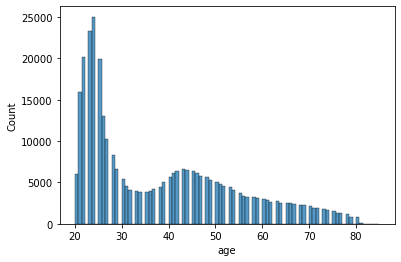

In [28]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

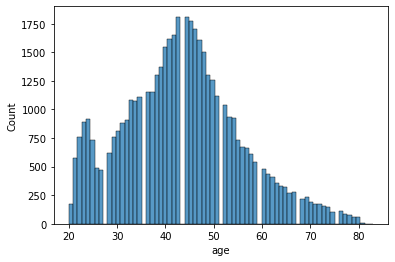

In [30]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='response', ylabel='driving_license'>

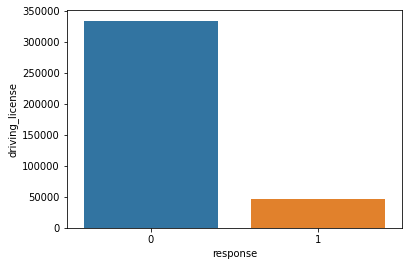

In [31]:
# driving license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )

In [32]:
pd.crosstab( df4['driving_license'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

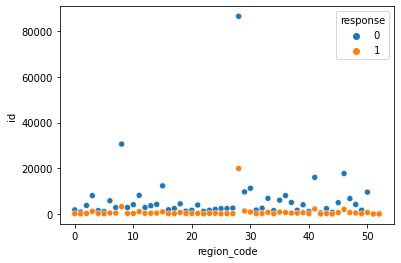

In [33]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

<AxesSubplot:xlabel='previously_insured', ylabel='id'>

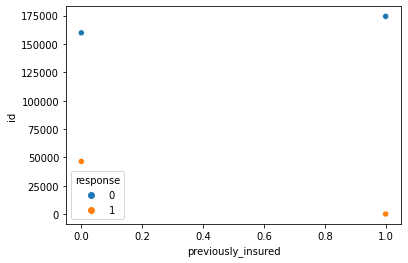

In [34]:
# previously_insured
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [36]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [37]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


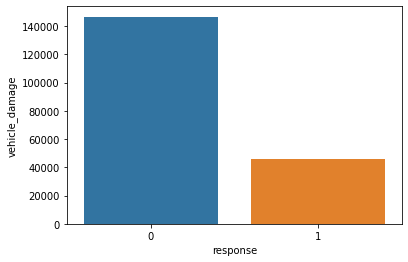

In [38]:
# vehicle_damage
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

In [27]:
# annual_premium

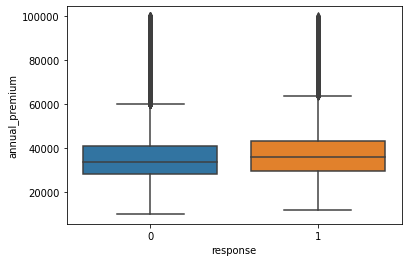

In [39]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]
sns.boxplot( x='response', y='annual_premium', data=aux );

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

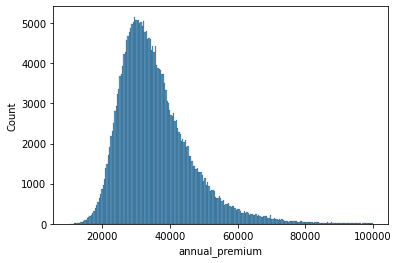

In [40]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

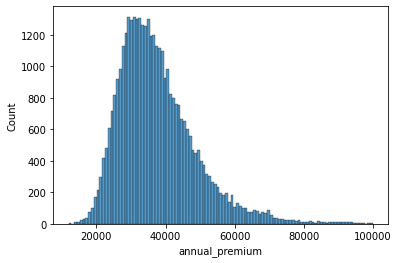

In [41]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

In [42]:
# policy_sales_channel
#aux = pd.crosstab( df4['policy_sales_channel'], df4['response'] ).reset_index()
#aux.columns = ['policy_sales_channel', 'no', 'yes']
#aux.set_index( 'policy_sales_channel' );
aux = df4[['policy_sales_channel', 'response']].groupby( ['policy_sales_channel', 'response'] ).size().reset_index()
aux.columns = ['policy_sales_channel', 'response', 'number']
aux = aux[aux['number'] < 1000]
aux.head()

,policy_sales_channel,response,number
1,1.0,1,35
2,2.0,0,3
3,2.0,1,1
4,3.0,0,364
5,3.0,1,159


<AxesSubplot:xlabel='policy_sales_channel', ylabel='number'>

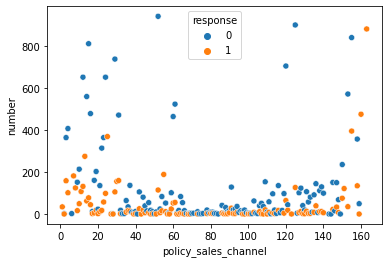

In [43]:
sns.scatterplot( x='policy_sales_channel', y='number', hue='response', data=aux )

In [47]:
# fig, ax = plt.subplots( 1, figsize=(16,6) )

# x = np.arange( 0, len( aux.index ) )

# # plot bars
# plt.bar( x - 0.1, aux[1], color='red' )
# plt.bar( x + 0.1, aux[0], color='blue' )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

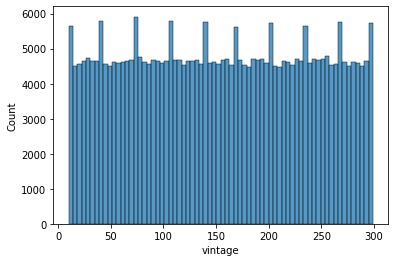

In [48]:
# vintage
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux0 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

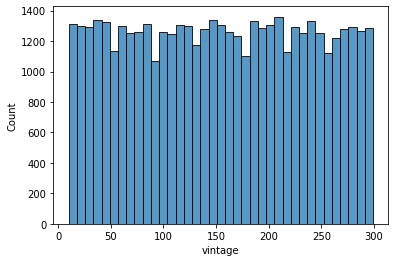

In [49]:
# vintage
aux0 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux0 )

# 5.0. Data Preparation

In [58]:
df4=df3.copy()

In [59]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [60]:
ss = pp.StandardScaler()
# annual premium - Standard Scaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [61]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMax Scaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage - MinMax Scaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Transformation

In [62]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] =  df5.loc[:, 'gender'].map( target_encode_gender )

# region_code - Frequency Encoding / Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] =  df5.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Frequency Encoding / Target Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5.loc[:, 'policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4. Validation

In [63]:
# gender
x_val.loc[:, 'gender'] =  x_val.loc[:, 'gender'].map( target_encode_gender )

# age
x_val.loc[:, 'age'] = mms_age.transform( x_val[['age']].values )

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform( x_val[['annual_premium']].values )

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform( x_val[['vintage']].values )

# fillna
x_val = x_val.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Boruta Algorithms

## 6.2. Tree-Based Model Feature Importance

In [64]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
et_model.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

feature ranking
                        feature  importance
0                       vintage    0.272140
0                annual_premium    0.244588
0                           age    0.166141
0                   region_code    0.105297
0                vehicle_damage    0.067837
0          policy_sales_channel    0.059480
0            previously_insured    0.056650
0      vehicle_age_below_1_year    0.014150
0  vehicle_age_between_1_2_year    0.006307
0                        gender    0.004813
0      vehicle_age_over_2_years    0.002126
0               driving_license    0.000471


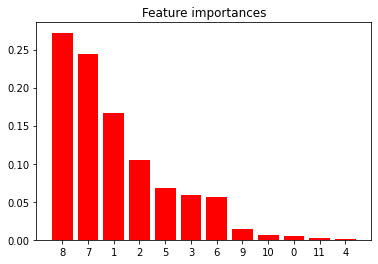

In [65]:
importances = et_model.feature_importances_
indices = np.argsort( importances )[::-1]

print( 'feature ranking')
df = pd.DataFrame()

for i, j in zip( x_train_n, et_model.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Model

In [66]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [67]:
x_train = df5[ cols_selected ]
x_val = x_val[ cols_selected ]

## 7.1. K-NN

In [68]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model predicion
yhat_knn = knn_model.predict_proba( x_val )

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

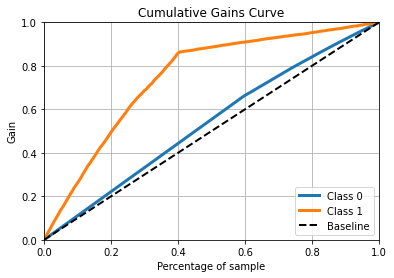

In [69]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

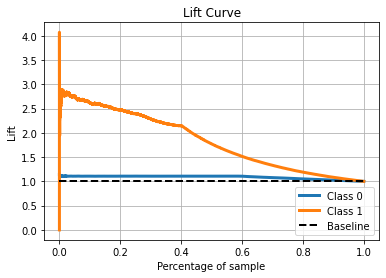

In [70]:
# Lift
skplt.metrics.plot_lift_curve( y_val, yhat_knn )

## 7.2. Logistic Regression

In [71]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model predicion
yhat_lr = lr_model.predict_proba( x_val )

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

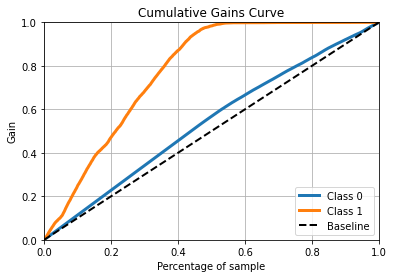

In [72]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr )

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

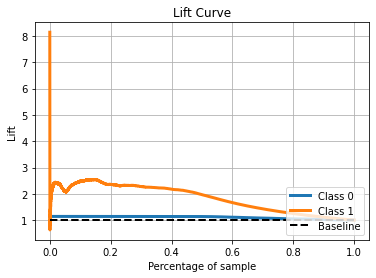

In [73]:
# Lift
skplt.metrics.plot_lift_curve( y_val, yhat_lr )

## 7.3. ExtraTrees

In [74]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model training
et_model.fit( x_train, y_train )

# model predicion
yhat_et = et_model.predict_proba( x_val )

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

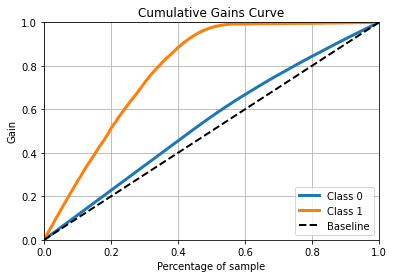

In [75]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et )

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

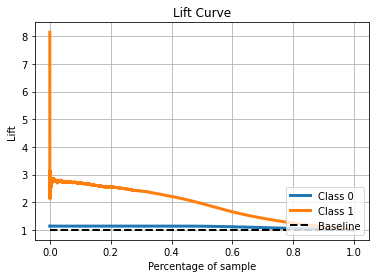

In [76]:
# Lift
skplt.metrics.plot_lift_curve( y_val, yhat_et )